# Model-4: Residual Blocks, Depthwise Separable Convolutions and Inception Layers

- Residual Blocks add skip connections to improve gradient flow and feature reuse
- Depthwise Separable Convolution reduces the number of parameters while maintaining performance
- Inception blocks allow multi-scale feature extraction

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets

In [2]:
try:
    from torchinfo import summary
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchinfo"])
    from torchinfo import summary

In [3]:
try:
    import torchmetrics
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchmetrics"])
    import torchmetrics

In [4]:
import os
repo_url = "https://raw.githubusercontent.com/vardanskamra/Deep-Multimedia-Steganography/main/utils"
files = [
    "__init__.py",
    "test.py",
    "train.py",
    "metrics.py",
    "transforms.py",
    "visualizations.py",
    "inference.py"
]
os.makedirs("utils", exist_ok=True)

for file in files:
    file_url = f"{repo_url}/{file}"
    os.system(f"curl -s {file_url} -o utils/{file}")

print("Downloaded all utils files successfully!")

Downloaded all utils files successfully!


In [5]:
import sys
sys.path.append("./utils") 

In [6]:
import utils

from utils.transforms import train_test_transform
from utils.metrics import loss_function
from utils.train import train
from utils.test import test

from utils.visualizations import plot_metrics
from utils.visualizations import visualize_images

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=train_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Train DataLoader Length: {len(train_loader)}")
print(f"Test DataLoader Length: {len(test_loader)}")

sample, label = next(iter(train_loader))
print(f"Sample Shape: {sample.shape}")
print(f"Label Shape: {label.shape}")

Train Dataset Length: 50000
Test Dataset Length: 10000
Train DataLoader Length: 1563
Test DataLoader Length: 313
Sample Shape: torch.Size([32, 3, 128, 128])
Label Shape: torch.Size([32])


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [11]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, stride=stride, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.relu(self.bn(x))

In [12]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_channels // 4, kernel_size=1, padding=0)
        self.branch2 = ConvBlock(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.branch3 = ConvBlock(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels // 4, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        return out + residual

In [14]:
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.layers = nn.Sequential(
            InceptionModule(3, 128),
            ResidualBlock(128, 128),
            DepthwiseSeparableConv(128, 128),
            ResidualBlock(128, 128),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, secret):
        return self.layers(secret)


In [15]:
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.layers = nn.Sequential(
            InceptionModule(6, 128),
            ResidualBlock(128, 128),
            DepthwiseSeparableConv(128, 128),
            ResidualBlock(128, 128),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, cover, secret_prepared):
        x = torch.cat([cover, secret_prepared], dim=1)
        return self.layers(x)

In [16]:
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.layers = nn.Sequential(
            InceptionModule(3, 128),
            ResidualBlock(128, 128),
            DepthwiseSeparableConv(128, 128),
            ResidualBlock(128, 128),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, stego):
        return self.layers(stego)

In [17]:
print(f"Device: {device}")
prep_net = nn.DataParallel(PrepNetwork()).to(device)
hide_net = nn.DataParallel(HidingNetwork()).to(device)
reveal_net = nn.DataParallel(RevealNetwork()).to(device)

Device: cuda


In [18]:
print("PrepNetwork Summary:")
print(summary(prep_net, input_size=(32, 3, 128, 128)))

cover = torch.randn(32, 3, 128, 128)
secret_prepared = torch.randn(32, 3, 128, 128)

print("\nHidingNetwork Summary:")
print(summary(hide_net, input_data=[cover, secret_prepared])) # 6 channels (cover + secret_prepared)

print("\nRevealNetwork Summary:")
print(summary(reveal_net, input_size=(32, 3, 128, 128)))

PrepNetwork Summary:
Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [32, 3, 128, 128]         --
├─PrepNetwork: 1-1                                 [16, 3, 128, 128]         616,707
├─PrepNetwork: 1-4                                 --                        (recursive)
│    └─Sequential: 2-1                             [16, 3, 128, 128]         616,707
│    └─Sequential: 2-4                             --                        (recursive)
│    │    └─InceptionModule: 3-1                   [16, 128, 128, 128]       3,840
│    │    └─InceptionModule: 3-7                   --                        (recursive)
├─PrepNetwork: 1-3                                 [16, 3, 128, 128]         --
├─PrepNetwork: 1-4                                 --                        (recursive)
│    └─Sequential: 2-3                             [16, 3, 128, 128]         --
│    └─Sequential: 2-4                       

In [19]:
optimizer = torch.optim.Adam(list(prep_net.parameters()) +
                       list(hide_net.parameters()) +
                       list(reveal_net.parameters()), lr=0.001)

In [20]:
train_metrics = train(dataloader=train_loader,
                prep_net=prep_net,
                hide_net=hide_net,
                reveal_net=reveal_net,
                optimizer=optimizer,
                loss_fn=loss_function,
                beta=0.75,
                epochs=25,
                device=device)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/25], Loss: 0.0395, PSNR: 18.2782, SSIM: 0.7717, NC: 0.8599, Pixel Loss (Cover-Stego): 0.0902, Pixel Loss (Secret-Revealed): 0.1105
Epoch [2/25], Loss: 0.0203, PSNR: 20.4238, SSIM: 0.8520, NC: 0.9155, Pixel Loss (Cover-Stego): 0.0671, Pixel Loss (Secret-Revealed): 0.0884
Epoch [3/25], Loss: 0.0155, PSNR: 21.3443, SSIM: 0.8711, NC: 0.9365, Pixel Loss (Cover-Stego): 0.0613, Pixel Loss (Secret-Revealed): 0.0763
Epoch [4/25], Loss: 0.0132, PSNR: 21.9584, SSIM: 0.8800, NC: 0.9478, Pixel Loss (Cover-Stego): 0.0567, Pixel Loss (Secret-Revealed): 0.0694
Epoch [5/25], Loss: 0.0136, PSNR: 21.7993, SSIM: 0.8730, NC: 0.9461, Pixel Loss (Cover-Stego): 0.0584, Pixel Loss (Secret-Revealed): 0.0697
Epoch [6/25], Loss: 0.0110, PSNR: 22.6581, SSIM: 0.8874, NC: 0.9576, Pixel Loss (Cover-Stego): 0.0524, Pixel Loss (Secret-Revealed): 0.0630
Epoch [7/25], Loss: 0.0108, PSNR: 22.6771, SSIM: 0.8857, NC: 0.9611, Pixel Loss (Cover-Stego): 0.0520, Pixel Loss (Secret-Revealed): 0.0600
Epoch [8/25], Loss: 

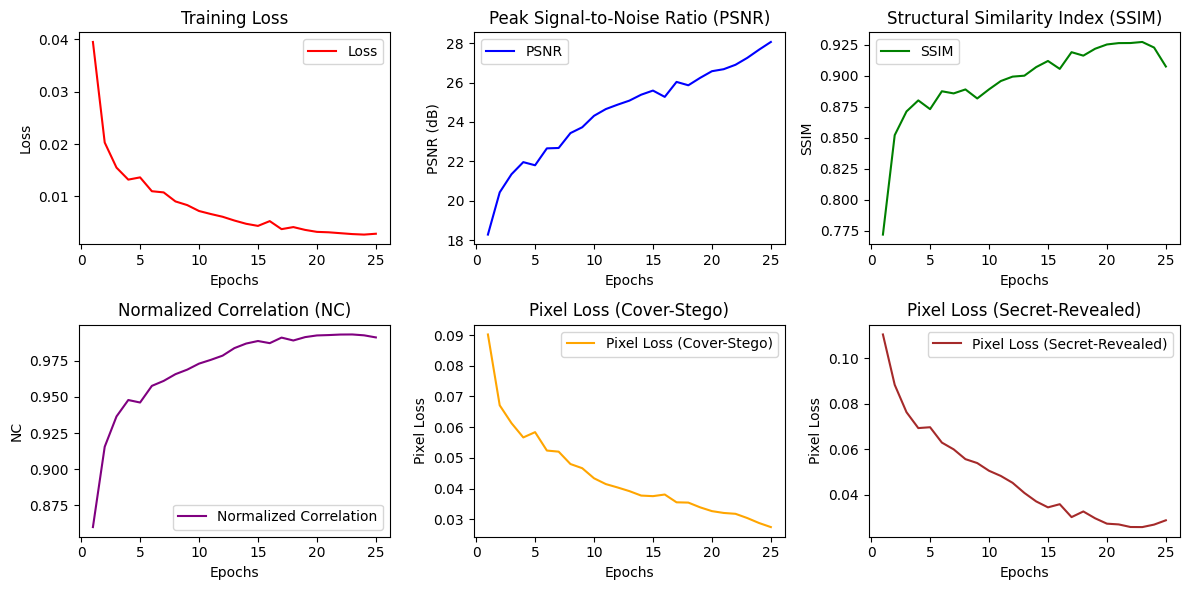


Final Evaluation Metrics:
Final Loss: 0.0029
Final PSNR: 28.0623 dB
Final SSIM: 0.9074
Final Normalized Correlation (NC): 0.9912
Final Pixel Loss (Cover-Stego): 0.0274
Final Pixel Loss (Secret-Revealed): 0.0288



In [21]:
plot_metrics(train_metrics)

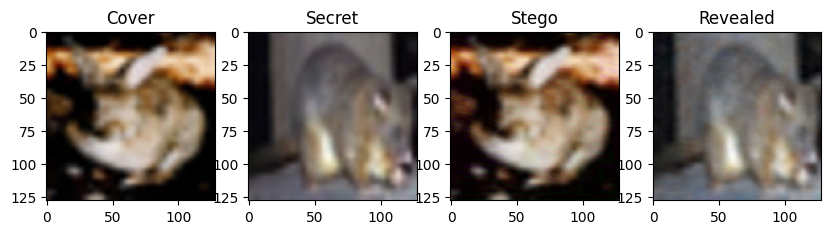

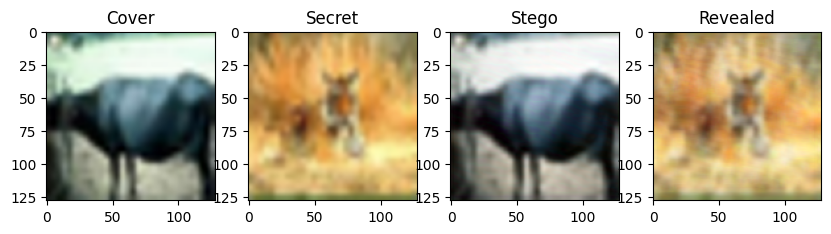

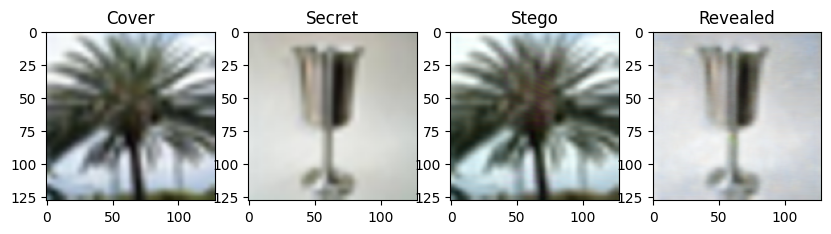

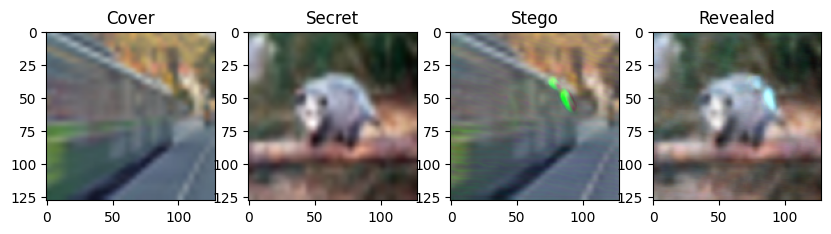

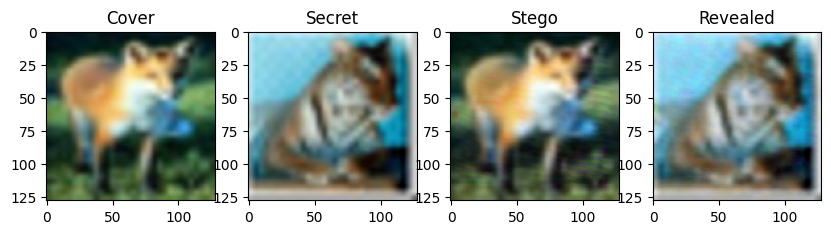

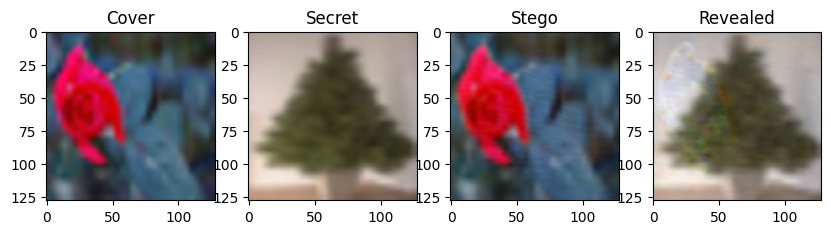

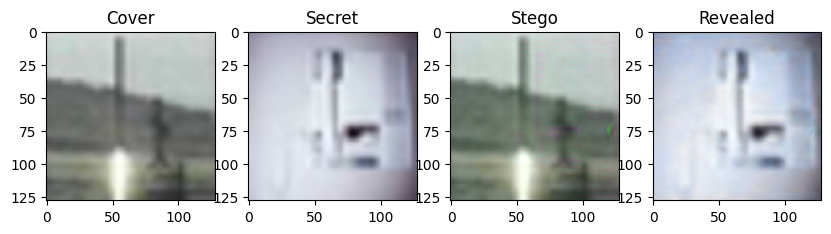

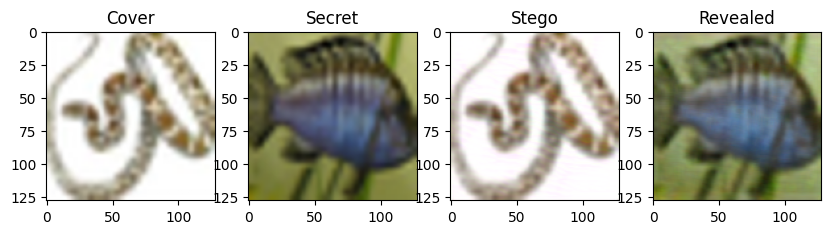

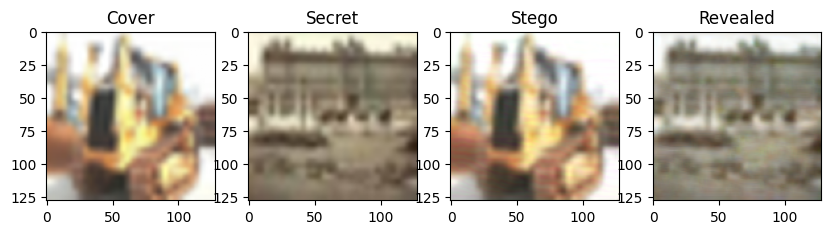

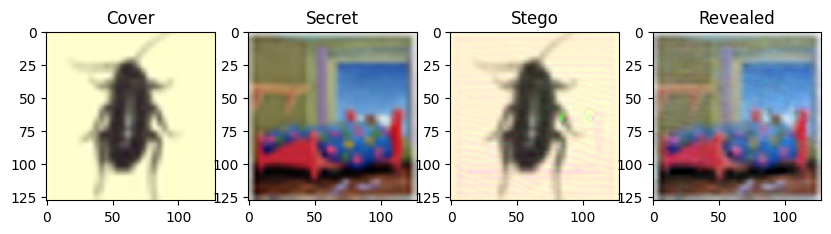

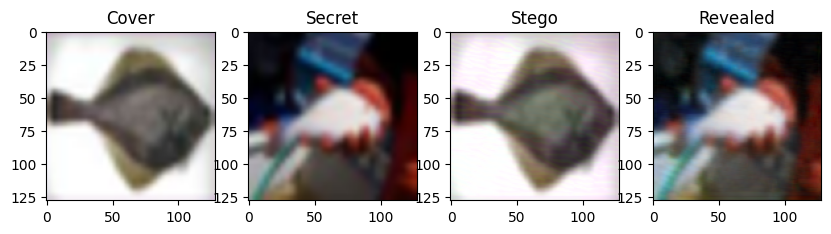

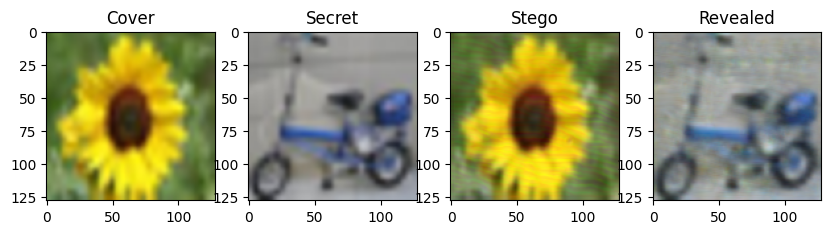

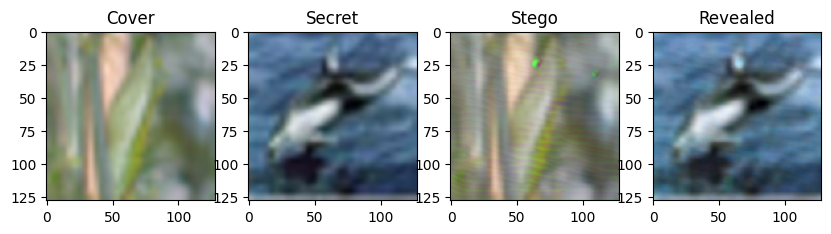

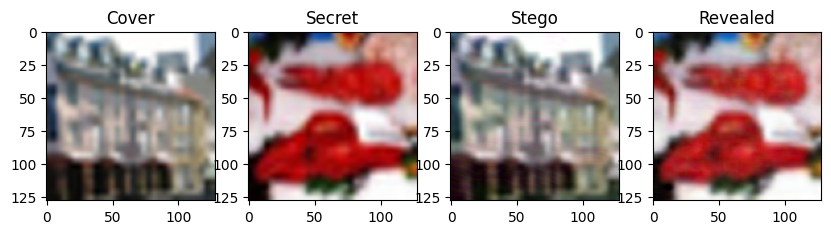

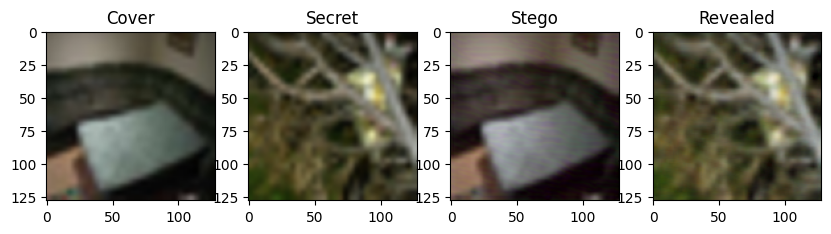


Test Results: Loss: 0.0023, PSNR: 31.5047, SSIM: 0.9214, NC: 0.9928, Pixel Loss (Cover-Stego): 0.0188, Pixel Loss (Secret-Revealed): 0.0380



In [22]:
test_metrics = test(prep_net=prep_net,
               hide_net=hide_net,
               reveal_net=reveal_net,
               dataloader=test_loader,
               loss_fn = loss_function,
               beta = 0.75,
               visualize = True,
               device=device)

In [23]:
checkpoint = {
    'epoch': 25, # New training stars from epoch 25, we've done 0-24
    'prep_net_state_dict': prep_net.module.state_dict(),
    'hide_net_state_dict': hide_net.module.state_dict(),
    'reveal_net_state_dict': reveal_net.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, "model_checkpoint.pth")

In [24]:
torch.save(prep_net.state_dict(), "/kaggle/working/prep_net.pth")
torch.save(hide_net.state_dict(), "/kaggle/working/hide_net.pth")
torch.save(reveal_net.state_dict(), "/kaggle/working/reveal_net.pth")